In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install fastai==1.0.61

In [3]:
# !pip install timm

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image
import os
from glob import glob
import cv2
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

In [5]:
from utils import interleave, de_interleave, show_batch, AverageMeter, show_grid
from learner import FixMatch, BaseLine
from dataset import GIDataset, get_transform

In [6]:
_HYPER_KVASIR = 'D:\\data\\endoscopic\\hyper_kvasir\\labeled_images_deform'
_RESOURCE = '../resource/hyper_kvasir/full_labeled_anno.csv'

In [7]:
%pwd

'C:\\Users\\Admin\\working\\python\\mine\\endoscopic\\code'

In [8]:
df_full = pd.read_csv(_RESOURCE)
df_full.head()

,Organ,Classification,Finding,Image,Categories,is_valid
0,upper-gi-tract,anatomical-landmarks,z-line,upper-gi-tract/anatomical-landmarks/z-line/c7e...,0,False
1,lower-gi-tract,therapeutic-interventions,dyed-lifted-polyps,lower-gi-tract/therapeutic-interventions/dyed-...,0,False
2,lower-gi-tract,quality-of-mucosal-views,bbps-2-3,lower-gi-tract/quality-of-mucosal-views/bbps-2...,0,False
3,lower-gi-tract,quality-of-mucosal-views,bbps-2-3,lower-gi-tract/quality-of-mucosal-views/bbps-2...,0,False
4,upper-gi-tract,anatomical-landmarks,z-line,upper-gi-tract/anatomical-landmarks/z-line/b98...,0,False


In [9]:
# df_full['Categories'].value_counts()

In [10]:
config = {}

config['data_path'] = _HYPER_KVASIR
config['size'] = 224
config['num_classes'] = 13
config['batch_size'] = 16
config['num_workers'] = 0
config['output_nodes'] = 1
config['epochs'] = 10
config['lr'] = 1e-3
config['mu'] = 7

config['lr'] = 1e-3
config['lr_step_size'] = 10
config['lr_gamma'] = 0.8

config['momentum'] = 0.9
config['weight_decay'] = 0.05
config['eval_step'] = 16
config['threshold'] = 0.95
config['T'] = 1.0
config['lambda_u'] = 0.9
config['freq_eval'] = 1
config['sch_name'] = 'step'
config['use_ema'] = True
config['ema_decay'] = 0.999

In [11]:
df_train = df_full[df_full['is_valid']==False]
## break down into labeled and unlabeled set
# df_labeled, df_unlabeled = train_test_split(df_train, test_size = 0.9, random_state = 0)
# df_labeled = df_labeled.reset_index();
# df_unlabeled = df_unlabeled.reset_index();

In [12]:
# df_train

In [14]:
# train_labeled_ds = GIDataset(df = df_labeled, config = config, transforms = get_transform(config, is_train=True))
# train_unlabeled_ds = GIDataset(df = df_unlabeled, config = config, transforms = get_transform(config, is_train=True, is_labeled=False))
train_ds = GIDataset(df = df_full[df_full['is_valid']==False], config = config, transforms = get_transform(config, is_train=True))
valid_ds = GIDataset(df = df_full[df_full['is_valid']==True] , config = config, transforms = get_transform(config))

In [15]:
# train_labeled_dl = DataLoader(train_labeled_ds, 
#                               sampler=RandomSampler(train_labeled_ds),
#                               batch_size = config['batch_size'], 
#                               num_workers = config['num_workers'])

# train_unlabeled_dl = DataLoader(train_unlabeled_ds, 
#                               sampler=RandomSampler(train_unlabeled_ds),
#                               batch_size = config['batch_size']*config['mu'], 
#                               num_workers = config['num_workers'])

train_dl = DataLoader(train_ds, 
                      sampler=RandomSampler(train_ds),
                      batch_size = config['batch_size'], 
                      num_workers = config['num_workers'])

valid_dl = DataLoader(valid_ds, 
                      sampler=SequentialSampler(valid_ds),
                      batch_size = config['batch_size'], 
                      num_workers = config['num_workers'])

torch.Size([16, 3, 224, 224])
tensor([ 0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0])


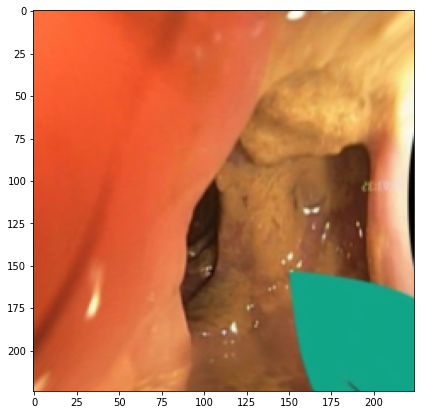

In [20]:
for x, y in train_dl:
    print(x.shape)
    print(y)
    break
show_batch(x[0,:,:])

torch.Size([16, 3, 224, 224])
tensor([ 0,  0,  0,  0,  0, 10,  0,  0,  4,  0,  0, 10,  0,  5, 12,  0])


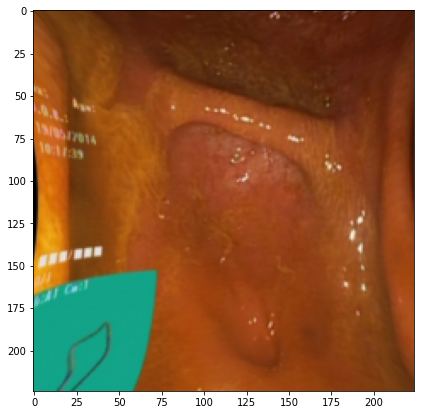

In [21]:
for x, y in valid_dl:
    print(x.shape)
    print(y)
    break
show_batch(x[0,:,:])

In [ ]:
x[0][100,:,:].shape

In [ ]:
# for x, y in train_unlabeled_dl:
#     # print(x)
#     # print(y)
#     break
# show_grid([x[0][100,:,:]]+[x[1][100,:,:]])

In [ ]:
model = nn.Sequential(timm.create_model('densenet161',pretrained=True,num_classes = config['num_classes']))

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
classifier = BaseLine(model = model,
                      opt_func="Adam", 
                      device = device)

classifier.get_config(config)
classifier.get_dataloader((train_labeled_dl, train_unlabeled_dl), valid_dl)

In [ ]:
classifier.fit()

In [ ]:
# classifier.save_checkpoint('./')

In [ ]:
# classifier.load_checkpoint('./05_08_2022_19_21_56.pth')